### Load packages and sample data

In [1]:
import shlex
import re
import pandas as pd
from typing import List
import utils

In [2]:
fields_to_include = ["OWNER","TITLE", "ABSTRACT", "SERVICETYPE", "SERVICELINK", "KEYWORDS"]
fields_to_output = ["OWNER","TITLE", "SERVICETYPE", "SERVICELINK"]
url_github_repo = "https://github.com/davidoesch/geoservice_harvester_poc/blob/main/data/"
url_github_repo_suffix = "?raw=true"
url_geoservices_CH_csv = "{}geoservices_CH.csv{}".format(url_github_repo,url_github_repo_suffix)
a = 'Strassen auswertung system'

def split_delimiters(word_list_with_delimiters: List[str]) -> List[str]:
    """Take care of left over delimiters, split strings even if in qoutes
        Return a list of words """
    delimiters = [";", ","]

    new_word_list = []

    for word in word_list_with_delimiters:
        if (any(delimiter in word for delimiter in delimiters)):
            splitted_words = re.split(r',|;', word)
            for splitted_word_ in splitted_words:
                new_word_list.append(splitted_word_)
        else:
            new_word_list.append(word)
    return new_word_list

def load_data():
    dataframe = pd.read_csv(url_geoservices_CH_csv, usecols=fields_to_include)
    return dataframe

res = split_delimiters(shlex.split(a))
dataframe_some_cols = load_data()
result = dataframe_some_cols[dataframe_some_cols.apply(lambda dataset: dataset.astype(str).str.contains(res[0], case=False).any(), axis=1)]
database =result.fillna("empty")

### Improvement of the TF-IDF with BM25 to execute queries on the text

In [7]:
# abstracts = result['ABSTRACT'].values.tolist()
bm25 = utils.TFIDF_BM25()
bm25.cleansing_ranking(database, column='ABSTRACT') # 1421 lines in 36 s

In [6]:
# fit the vector to the database
bm25.fit()
# search the best match in the vector
res = bm25.search('Brandmeldeanlage')

In [7]:
for el in res:
    print(result.loc[el])

OWNER                                                      KT_AR
TITLE                                          Feuerwehrplan Gde
ABSTRACT       Der Übersichtsplan der Feuerwehr enthält folge...
KEYWORDS                                                     NaN
SERVICELINK    https://www.geoportal.ch/services/wms/ktar?ser...
SERVICETYPE                                                  WMS
Name: 224, dtype: object


### Keyword extraction with rake_nltk (uses TF-IDF as well)

In [24]:
rake = utils.KeywordsRake()
keywords = rake.extract_keywords(database, column='ABSTRACT', score=False, keyword_length=3)

In [27]:
keywords[0][:10]

['wms service geoportal',
 'kanton appenzell innerrhoden',
 'meteorwasser sowie versickerungsanlagen',
 'karte zeigt',
 'kanalisationsnetz dargestellt',
 'darin ersichtlich',
 'sowie',
 'ölabscheider',
 'werkleitungen',
 'teilweise']

In [26]:
database['ABSTRACT'].values.tolist()[10]

"Die Karte zeigt, welcher Lärmbelastung die Bevölkerung durch den Strassenverkehr in der Nacht ausgesetzt ist. Die Angaben basieren auf flächendeckenden Modellberechnungen (sonBASE). Das gesamte Strassennetz der Schweiz, das in diese Berechnung einbezogen wurde, umfasst ca. 68'000 km. Die Verkehrsdaten für den Strassenverkehr wurden mit einem Mobilitätsmodell für das Jahr 2015 ermittelt. Die so ermittelten Verkehrsdaten wurden auf der Grundlage von ca. 1900 nationalen und kantonalen Zählstellen mit stundenfeinen Zählwerten kalibriert. Daten sind gesetzlich nicht verbindlich. Verbindliche Angaben zur Belastung wie auch zur Lärmsanierung geben die jeweiligen Vollzugsbehörden. Bei Nationalstrassen: Bundesamt für Strassen (ASTRA). Bei Haupt- und übrige Strassen: Die Kantonalen Vollzugsbehörden. WMS Service Geoportal - Kanton Appenzell Innerrhoden"

### Implement the classification and keyword extraction with spacy (NLP)

In [22]:
NLP = utils.NLP_spacy()
# Keyword
keywords_NLP = NLP.extract_keywords(database, column='ABSTRACT') # with small models

In [28]:
keywords_NLP[0]

[Geoportal]

In [15]:
# Original abstract
database['ABSTRACT'].values.tolist()[0]

'Diese Karte zeigt die Werkleitungen der Abwasserentsorgung an. Es wird die Strassenentwässerung und Liegenschaftsentwässerung (teilweise mit Hausanschluss) sowie das Kanalisationsnetz dargestellt. Darin ersichtlich sind unter anderem Leitungen mit Schmutzabwasser, Mischabwasser, Regenabwasser, Meteorwasser sowie Versickerungsanlagen, Kontrollschächte, Einlaufschächte und Ölabscheider. WMS Service Geoportal - Kanton Appenzell Innerrhoden'

### Test LSA and LSI with gensim for topic modelling

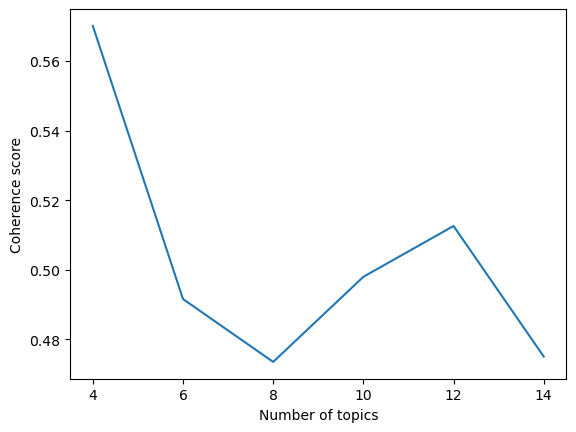

In [3]:
LSA = utils.LSI()
abstracts = LSA.preprocess(database)
LSA.compute_coherence_values((4,16,2))

In [8]:
best_number_topics = 12
number_of_words = 20
lsamodel = LSA.create_gensim_lsa_model(best_number_topics, number_of_words)

[(0, '-0.439*"art" + -0.433*"tvav" + -0.239*"enthalt" + -0.209*"dateneb" + -0.199*"definiert" + -0.192*"punkt" + -0.172*"fehl" + -0.172*"mittl" + -0.172*"toleranzstuf" + -0.172*"standardabweich" + -0.172*"richt" + -0.165*"kategori" + -0.144*"lagegenau" + -0.115*"bzw." + -0.096*"grenzpunkt" + -0.089*"geeignet" + -0.088*"auss" + -0.088*"zuverlass" + -0.088*"kenngross" + -0.088*"nachgewies"'), (1, '-0.416*"kanton" + -0.292*"wurd" + -0.281*"bern" + -0.232*"datensatz" + -0.230*"https" + -0.209*"//geofiles.be.ch/geoportal/pub/vertrieb/agi_dv_nutzungsbedingungen_de.pdf" + -0.147*"\'\'" + -0.146*"``" + -0.138*"gemass" + -0.129*"fff" + -0.129*"kantonal" + -0.121*"flach" + -0.116*"sitz" + -0.111*"gewasserraum" + -0.101*"strass" + -0.099*"grenz" + -0.094*"dat" + -0.092*"enthalt" + -0.089*"gemeind" + -0.088*"generalisiert"'), (2, '-0.436*"sitz" + 0.335*"\'\'" + 0.333*"``" + -0.326*"bern" + 0.306*"datensatz" + -0.147*"https" + -0.142*"//geofiles.be.ch/geoportal/pub/vertrieb/agi_dv_nutzungsbedingung

In [9]:
lsamodel.print_topics(best_number_topics, number_of_words)

[(0,
  '-0.439*"art" + -0.433*"tvav" + -0.239*"enthalt" + -0.209*"dateneb" + -0.199*"definiert" + -0.192*"punkt" + -0.172*"fehl" + -0.172*"mittl" + -0.172*"toleranzstuf" + -0.172*"standardabweich" + -0.172*"richt" + -0.165*"kategori" + -0.144*"lagegenau" + -0.115*"bzw." + -0.096*"grenzpunkt" + -0.089*"geeignet" + -0.088*"auss" + -0.088*"zuverlass" + -0.088*"kenngross" + -0.088*"nachgewies"'),
 (1,
  '-0.416*"kanton" + -0.292*"wurd" + -0.281*"bern" + -0.232*"datensatz" + -0.230*"https" + -0.209*"//geofiles.be.ch/geoportal/pub/vertrieb/agi_dv_nutzungsbedingungen_de.pdf" + -0.147*"\'\'" + -0.146*"``" + -0.138*"gemass" + -0.129*"fff" + -0.129*"kantonal" + -0.121*"flach" + -0.116*"sitz" + -0.111*"gewasserraum" + -0.101*"strass" + -0.099*"grenz" + -0.094*"dat" + -0.092*"enthalt" + -0.089*"gemeind" + -0.088*"generalisiert"'),
 (2,
  '-0.436*"sitz" + 0.335*"\'\'" + 0.333*"``" + -0.326*"bern" + 0.306*"datensatz" + -0.147*"https" + -0.142*"//geofiles.be.ch/geoportal/pub/vertrieb/agi_dv_nutzungsb

### Test Text Summarization and Latent Dirchlet allocation (LDA) for topic modeling

In [16]:
# TODO+
# https://towardsdatascience.com/text-summarization-for-clustering-documents-2e074da6437a
# https://towardsdatascience.com/nlp-topic-modeling-to-identify-clusters-ca207244d04f

# https://towardsdatascience.com/make-a-text-summarizer-with-gpt-3-f0917a07189e

#### Keywords extraction

In [10]:
NLP = utils.NLP_spacy()
topics = NLP.extract_topics_from_keywords(database, use_rake=True, column='ABSTRACT',
                                          keyword_length=3, num_keywords=3)
len(topics)
# BUG: the topics must be refined manually!!!

1047

In [11]:
list(topics)

['wochentage montag',
 'wichtigste instrument',
 'verschiedenen mobilfunknetzbetreiber',
 'nutzungsbedingungen',
 'entweder permanent erhoben',
 'kantonaler bedeutung bezeichnet',
 'hoheitsgrenzpunkte',
 'genau bezeichneten gemeindeteils',
 'realen versorgungssituationen',
 'grober erfassung ),',
 'schützenden objekte treffen',
 'mastergeodatenelement 2',
 'projektperimeter_ wms_kstn_strassenentwaesserung',
 'linienbezogenen festlegungen gehören',
 'leitungspunkt',
 'nummer',
 'liegenschaftsgrenzpunkte',
 'vorgaben',
 'amtlichen vermessung',
 'strassen gelangen',
 'vertrieb',
 'gesamtheitlichen landschaftsverständnisses steuern',
 'internet',
 'primarschulhäuser',
 'kantonalen stellen verpflichtet',
 'primarschulen',
 'gleichen strassenabschnitt verlaufen',
 'ökologischen aufwertung',
 'ogd',
 'mutmasslich belastetem bodenaushub',
 'strassen erfolgt',
 'bearbeitung befindenden bearbeitungsperimeter',
 'beim effizienten betrieb',
 'datenabgabe none',
 'strassennetz_anu_2015 wms_verkehrs

#### Text analysis

In [12]:
NLP = utils.NLP_spacy()
doc_labels, doc_dependencies = NLP.text_analysis(database['ABSTRACT'].values.tolist()[10])

In [13]:
doc_labels

,label,text
0,LOC,Schweiz
1,MISC,Jahr 2015
2,ORG,Nationalstrassen: Bundesamt für Strassen
3,MISC,Die Kantonalen Vollzugsbehörden.
4,LOC,Geoportal


In [14]:
doc_dependencies[doc_dependencies['positional'] == 'NOUN']

,text,lemma,grammar,dependency,positional
0,Karte,Karte,sb,zeigt,NOUN
2,Lärmbelastung,Lärmbelastung,da,ausgesetzt,NOUN
3,Bevölkerung,Bevölkerung,sb,ist,NOUN
5,Strassenverkehr,Strassenverkehr,nk,durch,NOUN
7,Nacht,Nacht,nk,in,NOUN
10,Angaben,Angabe,sb,basieren,NOUN
14,Modellberechnungen,Modellberechnung,nk,auf,NOUN
17,Strassennetz,Strassennetz,sb,umfasst,NOUN
21,Berechnung,Berechnung,nk,in,NOUN
27,km,km,oa,umfasst,NOUN


In [11]:
database['ABSTRACT'].values.tolist()[10]

"Die Karte zeigt, welcher Lärmbelastung die Bevölkerung durch den Strassenverkehr in der Nacht ausgesetzt ist. Die Angaben basieren auf flächendeckenden Modellberechnungen (sonBASE). Das gesamte Strassennetz der Schweiz, das in diese Berechnung einbezogen wurde, umfasst ca. 68'000 km. Die Verkehrsdaten für den Strassenverkehr wurden mit einem Mobilitätsmodell für das Jahr 2015 ermittelt. Die so ermittelten Verkehrsdaten wurden auf der Grundlage von ca. 1900 nationalen und kantonalen Zählstellen mit stundenfeinen Zählwerten kalibriert. Daten sind gesetzlich nicht verbindlich. Verbindliche Angaben zur Belastung wie auch zur Lärmsanierung geben die jeweiligen Vollzugsbehörden. Bei Nationalstrassen: Bundesamt für Strassen (ASTRA). Bei Haupt- und übrige Strassen: Die Kantonalen Vollzugsbehörden. WMS Service Geoportal - Kanton Appenzell Innerrhoden"

### Topic modeling with PyTorch models and predefined categories

In [18]:
# TODO
# https://github.com/davidoesch/geoservice_harvester_poc/issues/5

### Possible additional tests

In [ ]:
# Jaccard/Cosine similarity -> for query search
# WordNet-word-similarity -> for query search

### INSPIRE categories

In [67]:
import pandas as pd
df = pd.read_csv("data/INSPIRE_categories.csv", sep=';', encoding='UTF-16')
df.columns

Index(['category_EN', 'description_EN', 'category_DE', 'description_DE',
       'category_FR', 'description_FR', 'category_IT', 'description_IT',
       'complete_description'],
      dtype='object')

In [68]:
df.head()

,category_EN,description_EN,category_DE,description_DE,category_FR,description_FR,category_IT,description_IT,complete_description
0,Coordinate reference systems,Systems for uniquely referencing spatial infor...,Koordinatenreferenzsysteme,Systeme zur eindeutigen räumlichen Referenzier...,Référentiels de coordonnées,Systèmes de référencement unique des informati...,Sistemi di coordinate,Sistemi per referenziare in maniera univoca le...,The theme establishes a structure for spatial ...
1,Elevation,"Digital elevation models for land, ice and oce...",Höhe,"Digitale Höhenmodelle für Land-, Eis- und Meer...",Altitude,Modèles numériques pour l'altitude des surface...,Elevazione,Modelli digitali di elevazione per superfici e...,"The Elevation of a terrain surface, whether la..."
2,Statistical units,Units for dissemination or use of statistical ...,Statistische Einheiten,Einheiten für die Verbreitung oder Verwendung ...,Unités statistiques,Unités de diffusion ou d'utilisation d'autres ...,Unità statistiche,Unità per la divulgazione o l'utilizzo di dati...,Statistical unit informs on the location of st...
3,Geographical grid systems,Harmonised multi-resolution grid with a common...,Geografische Gittersysteme,Harmonisiertes Gittersystem mit Mehrfachauflös...,Systèmes de maillage géographique,Grille multi-résolution harmonisée avec un poi...,Sistemi di griglie geografiche,Griglia multi-risoluzione armonizzata con un p...,"Geographical grids are an agreed, defined and ..."
4,Land cover,Physical and biological cover of the earth's s...,Bodenbedeckung,Physische und biologische Bedeckung der Erdobe...,Occupation des terres,Couverture physique et biologique de la surfac...,Copertura del suolo,Copertura fisica e biologica della superficie ...,Land cover data is a physical or biological de...


### eCH categories

In [65]:
import pandas as pd
df = pd.read_csv("data/eCH_categories.csv", sep=';', encoding='UTF-16')
df.columns

Index(['ID', 'notation', 'category_EN', 'category_DE', 'category_FR',
       'category_IT', 'category_RM'],
      dtype='object')

In [66]:
df

,ID,notation,category_EN,category_DE,category_FR,category_IT,category_RM
0,111,A1,"Base Maps, Landscape Models","Basiskarten, Landschaftsmodelle","Cartes de référence, modèles du territoire","Carte di base, modelli del territorio","Chartas da basa, modellisaziun dal territori"
1,112,A2,"Land Cover, Land Use","Bodenbedeckung, Bodennutzung",Couverture et utilisation du sol,Copertura e utilizzo del suolo,Cuvrida ed utilisaziun dal terren
2,113,A3,Aerial and Satellite Imagery,"Luft-, Satellitenbilder",Images aériennes et satellitaires,Immagini aeree e satellitari,Maletgs e fotografias ord l'aria
3,120,B,"Location, Reference Systems","Ortsangaben, Referenzsysteme","Localisation, systèmes de référence","Localizzazione, sistemi di riferimento","Localitads, sistems da referenza"
4,130,C,Elevation,Höhen,Altimétrie,Altimetria,Altimetria
5,140,D,Political and Administrative Boundaries,Politische und administrative Grenzen,Limites politiques et administratives,Confini politici ed amministrativi,Cunfins politics ed administrativs
6,151,E1,"Spatial Planning, Spatial Development","Raumplanung, Raumentwicklung",Développement territorial,Pianificazione e sviluppo territoriale,Planisaziun e svilup dal territori
7,152,E2,"Cadastre, Land Registry",Grundstückskataster,Cadastre foncier,Catasto fondiario,Cataster
8,211,F1,Geology,Geologie,Géologie,Geologia,Geologia
9,212,F2,Soils,Boden,Sols,Suolo,Terren
